# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Dataset

In [2]:
data = pd.read_csv("ecommerce_customer_data_large.csv", sep=",")
data['Purchase Date'] = pd.to_datetime(data['Purchase Date'], format='%Y-%m-%d %H:%M:%S')
data = data.drop(columns=["Age"])
data = data.loc[data['Returns'].notnull()]

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202618 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Customer ID            202618 non-null  int64         
 1   Purchase Date          202618 non-null  datetime64[ns]
 2   Product Category       202618 non-null  object        
 3   Product Price          202618 non-null  int64         
 4   Quantity               202618 non-null  int64         
 5   Total Purchase Amount  202618 non-null  int64         
 6   Payment Method         202618 non-null  object        
 7   Customer Age           202618 non-null  int64         
 8   Returns                202618 non-null  float64       
 9   Customer Name          202618 non-null  object        
 10  Gender                 202618 non-null  object        
 11  Churn                  202618 non-null  int64         
 12  IsWeekend              202618 non-null  int64    

In [ ]:
varUnivoche = ["Churn", "Gender", "Customer Name", "Customer Age"]
dataSameID = data[data["Customer ID"].duplicated(keep=False)]
for var in varUnivoche:
    output = (~dataSameID.groupby("Customer ID")[var].apply(lambda x: x.duplicated(keep=False))).sum()

    print(var+": "+str(output))

Churn: 0
Gender: 0
Customer Name: 0
Customer Age: 0


# New variables

### Aggregation vars

In [3]:
def ismale(x):
    if 'Male' in x.unique(): 
        return 1
    else:
        return 0

In [4]:
def is_weekend (x):
    if (x.weekday() >= 5):
        return 1
    else:
        return 0

In [5]:
data['IsWeekend'] = data['Purchase Date'].apply(lambda x: is_weekend(x))

In [6]:
dataAgg = data.groupby("Customer ID").agg(
    totPurchase = ('Total Purchase Amount', 'sum'), 
    meanPurchase = ('Total Purchase Amount', 'mean'),
    medianProdPrice = ('Product Price', 'median'), 
    totQuantity = ('Quantity', 'sum'), 
    meanQuantity = ('Quantity', 'mean'), 
    meanReturns = ('Returns', 'mean'),  # può essere considerato come prob. di fare Return
    numOrders = ('Customer ID', 'value_counts'), 
    last_PurchaseDate = ('Purchase Date', 'max'), 
    first_PurchaseDate = ('Purchase Date', 'min'), 
    propWeekend = ('IsWeekend', 'mean'), # prob di acquisto nel weekend
    isMale = ('Gender', lambda x: ismale(x)), 
    Churn = ('Churn', 'min'), 
    Age = ('Customer Age', 'min')
    ).reset_index()                       

In [7]:
dataAgg['CustomerPurchaseLife_monthly'] = ((dataAgg['last_PurchaseDate'].dt.year - dataAgg['first_PurchaseDate'].dt.year))*12 + (dataAgg['last_PurchaseDate'].dt.month - dataAgg['first_PurchaseDate'].dt.month)

In [8]:
dataAgg['Recency'] = (dataAgg['last_PurchaseDate'].max() - dataAgg['last_PurchaseDate']).dt.days

In [ ]:
# varSum = ['Quantity', 'Total Purchase Amount']

# def totFunction(var):
#     tempDF = pd.DataFrame()
#     tempDF[var] = data.groupby('Customer ID')[var].sum()
#     data[f'Tot_{var}'] = data['Customer ID'].map(tempDF[var])

# for var in varSum:
#    totFunction(var)

In [24]:
dataAgg.tail()

,Customer ID,totPurchase,meanPurchase,medianProdPrice,totQuantity,meanQuantity,meanReturns,numOrders,last_PurchaseDate,first_PurchaseDate,propWeekend,isMale,Churn,Age,MonthOfPurchasing
49141,49996,21762,3627.0,295.5,20,3.333333,0.333333,6,2022-09-19 00:20:18,2020-09-05 07:32:48,0.333333,0,0,45,24
49142,49997,5714,2857.0,199.0,8,4.000000,0.000000,2,2022-08-21 12:46:16,2021-07-22 19:03:00,0.500000,1,0,65,13
49143,49998,20495,2049.5,218.5,30,3.000000,0.600000,10,2023-08-31 11:32:30,2020-05-01 10:59:19,0.400000,0,1,31,39
49144,49999,12709,2541.8,133.0,15,3.000000,0.600000,5,2022-09-22 15:46:41,2020-07-23 06:56:05,0.000000,0,0,70,26
49145,50000,19893,3315.5,269.5,15,2.500000,0.500000,6,2023-05-14 08:15:09,2020-01-17 16:28:36,0.666667,0,0,29,40


In [10]:
data.sort_values(by='Customer ID').head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Gender,Churn,IsWeekend
160921,1,2021-04-08 18:33:34,Books,456,5,5148,Credit Card,67,0.0,Dominic Cline,Female,0,0
225935,2,2022-03-14 04:31:25,Home,376,4,4726,Cash,42,1.0,Crystal Day,Female,0,0
225937,2,2023-04-26 10:10:00,Electronics,461,5,604,Cash,42,0.0,Crystal Day,Female,0,0
225933,2,2023-07-03 17:26:19,Books,190,1,4693,Credit Card,42,1.0,Crystal Day,Female,0,0
225932,2,2020-07-31 16:27:41,Electronics,408,2,4777,PayPal,42,0.0,Crystal Day,Female,0,0


### Freq purchasing

In [159]:
# data.groupby(['Customer ID', 'Purchase Date']).agg({'Product Category': list})

In [9]:
def meanFreqPurchase(x):
    tempX = sorted(list(x))
    tempVal = []
    if len(tempX) == 1:
        output = None
    else:
        for i in range(1, len(tempX)):
            tempVal.append((tempX[i]-tempX[i-1]).days)
        output = sum(tempVal)/len(tempVal)
        tempVal = []
    
    return(output)

In [10]:
meanFreqPurch = data.groupby('Customer ID').agg({'Purchase Date': lambda x: meanFreqPurchase(x)})

In [56]:
meanFreqPurch.reset_index()

,Customer ID,Purchase Date
0,1,NaN
1,2,212.800000
2,3,NaN
3,4,155.500000
4,5,319.500000
...,...,...
49141,49996,148.000000
49142,49997,394.000000
49143,49998,134.666667
49144,49999,197.250000


In [11]:
dataAgg = dataAgg.merge(round(meanFreqPurch), how='left', on='Customer ID')
dataAgg = dataAgg.rename(columns={'Purchase Date': 'avgFreqPurchase_days'})

## Dicotom var

In [12]:
cutting = [0, 25, 35, 50, 60, 70]
dataAgg['AgeCut']=pd.cut(dataAgg['Age'], bins=cutting, labels=['18-25', '25-35', '35-50', '50-60', '60-70'])
dfAgeClass = pd.get_dummies(dataAgg.set_index('Customer ID')['AgeCut']).astype(int).reset_index()

dataAgg = dataAgg.merge(dfAgeClass, how='left', on='Customer ID')
colList = [i for i in dfAgeClass.columns if i!=('Customer ID' or 'AgeCut')]
for col in colList: 
    dataAgg = dataAgg.rename(columns={f'{col}': f'AgeClass_{col}'})

In [ ]:
# {k: str(k)+"-"+str(k-1) for k in cutting if k>0}

{25: '25-24', 35: '35-34', 50: '50-49', 60: '60-59', 70: '70-69'}

In [13]:
dataAgg

,Customer ID,totPurchase,meanPurchase,medianProdPrice,totQuantity,meanQuantity,meanReturns,numOrders,last_PurchaseDate,first_PurchaseDate,...,Age,CustomerPurchaseLife_monthly,Recency,avgFreqPurchase_days,AgeCut,AgeClass_18-25,AgeClass_25-35,AgeClass_35-50,AgeClass_50-60,AgeClass_60-70
0,1,5148,5148.000000,456.0,5,5.000000,0.000000,1,2021-04-08 18:33:34,2021-04-08 18:33:34,...,67,0,888,NaN,60-70,0,0,0,0,1
1,2,16481,2746.833333,372.0,18,3.000000,0.666667,6,2023-07-03 17:26:19,2020-07-31 16:27:41,...,42,36,72,213.0,35-50,0,0,1,0,0
2,3,4687,4687.000000,188.0,3,3.000000,0.000000,1,2023-02-03 03:58:07,2023-02-03 03:58:07,...,31,0,222,NaN,25-35,0,1,0,0,0
3,4,7826,1565.200000,328.0,19,3.800000,0.600000,5,2022-06-29 03:41:09,2020-10-12 22:03:10,...,37,20,441,156.0,35-50,0,0,1,0,0
4,5,7681,2560.333333,65.0,8,2.666667,1.000000,3,2022-03-25 08:43:48,2020-06-23 06:03:40,...,24,21,537,320.0,18-25,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49141,49996,21762,3627.000000,295.5,20,3.333333,0.333333,6,2022-09-19 00:20:18,2020-09-05 07:32:48,...,45,24,359,148.0,35-50,0,0,1,0,0
49142,49997,5714,2857.000000,199.0,8,4.000000,0.000000,2,2022-08-21 12:46:16,2021-07-22 19:03:00,...,65,13,388,394.0,60-70,0,0,0,0,1
49143,49998,20495,2049.500000,218.5,30,3.000000,0.600000,10,2023-08-31 11:32:30,2020-05-01 10:59:19,...,31,39,13,135.0,25-35,0,1,0,0,0
49144,49999,12709,2541.800000,133.0,15,3.000000,0.600000,5,2022-09-22 15:46:41,2020-07-23 06:56:05,...,70,26,356,197.0,60-70,0,0,0,0,1


In [ ]:
#lista = ['a', 'b', 'c', 'customer ID']
#new_list = []
#for element in lista:
    #if element != 'customer ID':
        #new_list.append(element)

In [ ]:
#new_list = [element for element in lista if element != 'customer ID']

### Freq dictionary

In [12]:
data.groupby('Customer ID')['Product Category'].value_counts()

Customer ID  Product Category
1            Books               1
2            Electronics         3
             Books               1
             Clothing            1
             Home                1
                                ..
49999        Electronics         1
             Home                1
50000        Clothing            4
             Books               1
             Home                1
Name: count, Length: 127352, dtype: int64

In [13]:
tempData = data.groupby('Customer ID')['Product Category'].value_counts()
freqProdCategory = {}

for (code_id, product_category), count in tempData.items():
    if code_id not in freqProdCategory:
        freqProdCategory[code_id] = {}
    freqProdCategory[code_id][product_category] = count

In [17]:
data.groupby('Customer ID')['Payment Method'].value_counts()

Customer ID  Payment Method
1            Credit Card       1
2            PayPal            3
             Cash              2
             Credit Card       1
3            Cash              1
                              ..
49999        Credit Card       1
             PayPal            1
50000        Credit Card       3
             Cash              2
             PayPal            1
Name: count, Length: 111032, dtype: int64

In [14]:
tempData = data.groupby('Customer ID')['Payment Method'].value_counts()
freqPaymentMethod = {}

for (code_id, payment_method), count in tempData.items():
    if code_id not in freqPaymentMethod:
        freqPaymentMethod[code_id] = {}
    freqPaymentMethod[code_id][payment_method] = count

In [15]:
freqPaymentMethod

{1: {'Credit Card': 1},
 2: {'PayPal': 3, 'Cash': 2, 'Credit Card': 1},
 3: {'Cash': 1},
 4: {'Cash': 2, 'PayPal': 2, 'Credit Card': 1},
 5: {'Cash': 1, 'Credit Card': 1, 'PayPal': 1},
 6: {'Credit Card': 4, 'PayPal': 4},
 7: {'Cash': 2, 'Credit Card': 2, 'PayPal': 1},
 8: {'Cash': 3, 'Credit Card': 2, 'PayPal': 2},
 9: {'Cash': 2, 'PayPal': 2, 'Credit Card': 1},
 10: {'Cash': 5, 'Credit Card': 2, 'PayPal': 1},
 11: {'Cash': 5, 'Credit Card': 1},
 12: {'PayPal': 2, 'Credit Card': 1},
 13: {'PayPal': 3, 'Cash': 2},
 14: {'Credit Card': 2, 'Cash': 1},
 15: {'Cash': 1, 'Credit Card': 1, 'PayPal': 1},
 16: {'Credit Card': 2},
 17: {'PayPal': 3, 'Cash': 2},
 18: {'PayPal': 1},
 19: {'Cash': 2, 'PayPal': 2},
 20: {'Cash': 2, 'Credit Card': 1, 'PayPal': 1},
 21: {'Credit Card': 2, 'PayPal': 2},
 22: {'Cash': 1, 'Credit Card': 1, 'PayPal': 1},
 23: {'Cash': 2, 'PayPal': 2, 'Credit Card': 1},
 24: {'Cash': 1, 'Credit Card': 1, 'PayPal': 1},
 25: {'Cash': 2, 'PayPal': 1},
 26: {'Cash': 1, 'PayPa

In [15]:
dfProdCat=pd.DataFrame.from_dict(freqProdCategory, orient='index').fillna(0)
dfProdCat.columns = ['ProdCategory_' + col for col in dfProdCat.columns]
dfProdCat['sum']=dfProdCat.sum(axis=1)
dfProdCat=dfProdCat.div(dfProdCat['sum'], axis=0)
dfProdCat=dfProdCat.drop(columns=['sum'])

In [16]:
dfPayMeth=pd.DataFrame.from_dict(freqPaymentMethod, orient='index').fillna(0)
dfPayMeth.columns = ['PaymentMethod_' + col for col in dfPayMeth.columns]
dfPayMeth['sum']=dfPayMeth.sum(axis=1)
dfPayMeth=dfPayMeth.div(dfPayMeth['sum'], axis=0)
dfPayMeth=dfPayMeth.drop(columns=['sum'])

In [17]:
dataAgg = dataAgg.merge(dfProdCat, how='left', left_on='Customer ID', right_index=True)

In [18]:
dataAgg = dataAgg.merge(dfPayMeth, how='left', left_on='Customer ID', right_index=True)

In [38]:
dataAgg[dataAgg.columns[:14]].head(3)

,Customer ID,totPurchase,meanPurchase,medianProdPrice,totQuantity,meanQuantity,meanReturns,numOrders,last_PurchaseDate,first_PurchaseDate,propWeekend,isMale,Churn,Age
0,1,5148,5148.000000,456.0,5,5.0,0.000000,1,2021-04-08 18:33:34,2021-04-08 18:33:34,0.000000,0,0,67
1,2,16481,2746.833333,372.0,18,3.0,0.666667,6,2023-07-03 17:26:19,2020-07-31 16:27:41,0.166667,0,0,42
2,3,4687,4687.000000,188.0,3,3.0,0.000000,1,2023-02-03 03:58:07,2023-02-03 03:58:07,0.000000,1,0,31


In [39]:
dataAgg[dataAgg.columns[14:]].head(3)

,CustomerPurchaseLife_monthly,Recency,avgFreqPurchase_days,AgeClass_18-25,AgeClass_25-35,AgeClass_35-50,AgeClass_50-60,AgeClass_60-70,ProdCategory_Books,ProdCategory_Electronics,ProdCategory_Clothing,ProdCategory_Home,PaymentMethod_Credit Card,PaymentMethod_PayPal,PaymentMethod_Cash
0,0,888,NaN,0,0,0,0,1,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000
1,36,72,213.0,0,0,1,0,0,0.166667,0.5,0.166667,0.166667,0.166667,0.5,0.333333
2,0,222,NaN,0,1,0,0,0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,1.000000


## Economic vars

In [20]:
# AvgOrderValue: meanPurchase
# PurchaseFrequency: avgFreqPurchase_days al contrario
dataAgg['PF'] = dataAgg['avgFreqPurchase_days'].max()-dataAgg['avgFreqPurchase_days']
dataAgg['PF'] = dataAgg['PF'].fillna(0.1)
# Fidelty: PF * num_order
dataAgg['Fidelty']=dataAgg['numOrders']*dataAgg['PF']
# CustomerLifespan
dataAgg['CL'] = dataAgg['CustomerPurchaseLife_monthly'] + 0.1

In [19]:
dataAgg['numOrders'].corr(dataAgg['avgFreqPurchase_days'])

np.float64(-0.48267611203004807)

In [25]:
dataAgg[dataAgg['avgFreqPurchase_days']>dataAgg['avgFreqPurchase_days'].mean()]['numOrders'].value_counts()

numOrders
3    5901
4    4797
2    4516
5    1547
Name: count, dtype: int64

In [28]:
dataAgg['Recency'].corr(dataAgg['CustomerPurchaseLife_monthly'])

np.float64(-0.6678976563418821)

<Axes: ylabel='Count'>

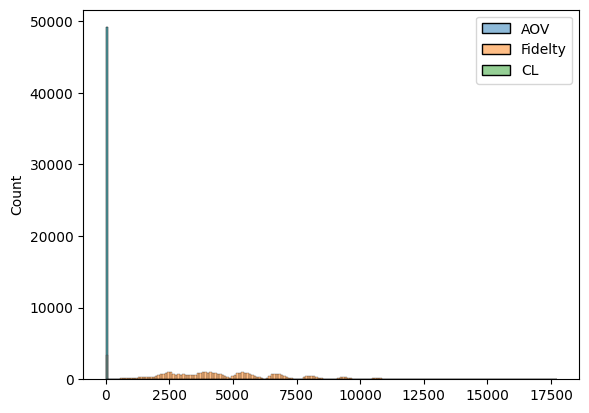

In [33]:
sns.histplot(dataAgg[['AOV', 'Fidelty', 'CL']])

<Axes: ylabel='Count'>

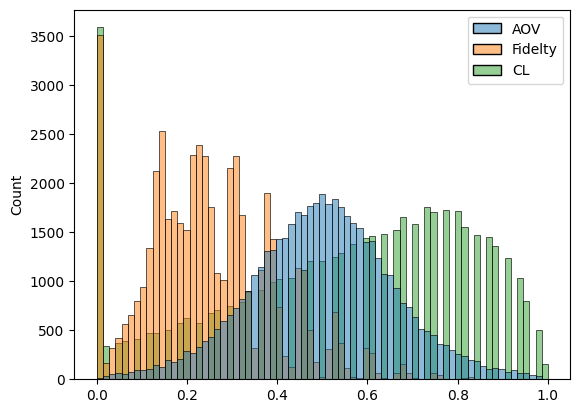

In [22]:
scaler=MinMaxScaler()
dataAgg[['AOV', 'Fidelty', 'CL']] = scaler.fit_transform(dataAgg[['meanPurchase', 'Fidelty', 'CL']])
sns.histplot(dataAgg[['AOV', 'Fidelty', 'CL']])


In [23]:
dataAgg['CLTV']=dataAgg['AOV']*dataAgg['Fidelty']*dataAgg['CL']

In [24]:
dataAgg['Churn'].corr(dataAgg['CLTV'])

np.float64(0.007448078283025191)

In [25]:
dataAgg.columns

Index(['Customer ID', 'totPurchase', 'meanPurchase', 'medianProdPrice',
       'totQuantity', 'meanQuantity', 'meanReturns', 'numOrders',
       'last_PurchaseDate', 'first_PurchaseDate', 'propWeekend', 'isMale',
       'Churn', 'Age', 'CustomerPurchaseLife_monthly', 'Recency',
       'avgFreqPurchase_days', 'AgeCut', 'AgeClass_18-25', 'AgeClass_25-35',
       'AgeClass_35-50', 'AgeClass_50-60', 'AgeClass_60-70',
       'ProdCategory_Books', 'ProdCategory_Electronics',
       'ProdCategory_Clothing', 'ProdCategory_Home',
       'PaymentMethod_Credit Card', 'PaymentMethod_PayPal',
       'PaymentMethod_Cash', 'PF', 'Fidelty', 'CL', 'AOV', 'CLTV'],
      dtype='object')

In [26]:
dataAgg = dataAgg.drop(columns=['PF', 'Fidelty', 'CL', 'AOV'])

In [27]:
data = dataAgg.set_index('Customer ID')

In [28]:
data

,totPurchase,meanPurchase,medianProdPrice,totQuantity,meanQuantity,meanReturns,numOrders,last_PurchaseDate,first_PurchaseDate,propWeekend,...,AgeClass_50-60,AgeClass_60-70,ProdCategory_Books,ProdCategory_Electronics,ProdCategory_Clothing,ProdCategory_Home,PaymentMethod_Credit Card,PaymentMethod_PayPal,PaymentMethod_Cash,CLTV
Customer ID,,,,,,,,,,,,,,,,,,,,,
1,5148,5148.000000,456.0,5,5.000000,0.000000,1,2021-04-08 18:33:34,2021-04-08 18:33:34,0.000000,...,0,1,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,16481,2746.833333,372.0,18,3.000000,0.666667,6,2023-07-03 17:26:19,2020-07-31 16:27:41,0.166667,...,0,0,0.166667,0.5,0.166667,0.166667,0.166667,0.500000,0.333333,0.155108
3,4687,4687.000000,188.0,3,3.000000,0.000000,1,2023-02-03 03:58:07,2023-02-03 03:58:07,0.000000,...,0,0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,7826,1565.200000,328.0,19,3.800000,0.600000,5,2022-06-29 03:41:09,2020-10-12 22:03:10,0.000000,...,0,0,0.400000,0.2,0.200000,0.200000,0.200000,0.400000,0.400000,0.041571
5,7681,2560.333333,65.0,8,2.666667,1.000000,3,2022-03-25 08:43:48,2020-06-23 06:03:40,0.000000,...,0,0,0.666667,0.0,0.000000,0.333333,0.333333,0.333333,0.333333,0.037987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,21762,3627.000000,295.5,20,3.333333,0.333333,6,2022-09-19 00:20:18,2020-09-05 07:32:48,0.333333,...,0,0,0.500000,0.0,0.000000,0.500000,0.000000,0.333333,0.666667,0.146081
49997,5714,2857.000000,199.0,8,4.000000,0.000000,2,2022-08-21 12:46:16,2021-07-22 19:03:00,0.500000,...,0,1,0.000000,0.5,0.500000,0.000000,0.000000,0.500000,0.500000,0.016286
49998,20495,2049.500000,218.5,30,3.000000,0.600000,10,2023-08-31 11:32:30,2020-05-01 10:59:19,0.400000,...,0,0,0.600000,0.2,0.200000,0.000000,0.400000,0.200000,0.400000,0.220232


# EDA

In [29]:
numericalVars = data.select_dtypes(include='number')
numericalVars = numericalVars.drop(columns=['isMale', 'Churn', 'AgeClass_18-25', 'AgeClass_25-35', 'AgeClass_35-50', 'AgeClass_50-60',
       'AgeClass_60-70']).columns
numericalVars.shape

(20,)

In [30]:
numericalVars

Index(['totPurchase', 'meanPurchase', 'medianProdPrice', 'totQuantity',
       'meanQuantity', 'meanReturns', 'numOrders', 'propWeekend', 'Age',
       'CustomerPurchaseLife_monthly', 'Recency', 'avgFreqPurchase_days',
       'ProdCategory_Books', 'ProdCategory_Electronics',
       'ProdCategory_Clothing', 'ProdCategory_Home',
       'PaymentMethod_Credit Card', 'PaymentMethod_PayPal',
       'PaymentMethod_Cash', 'CLTV'],
      dtype='object')

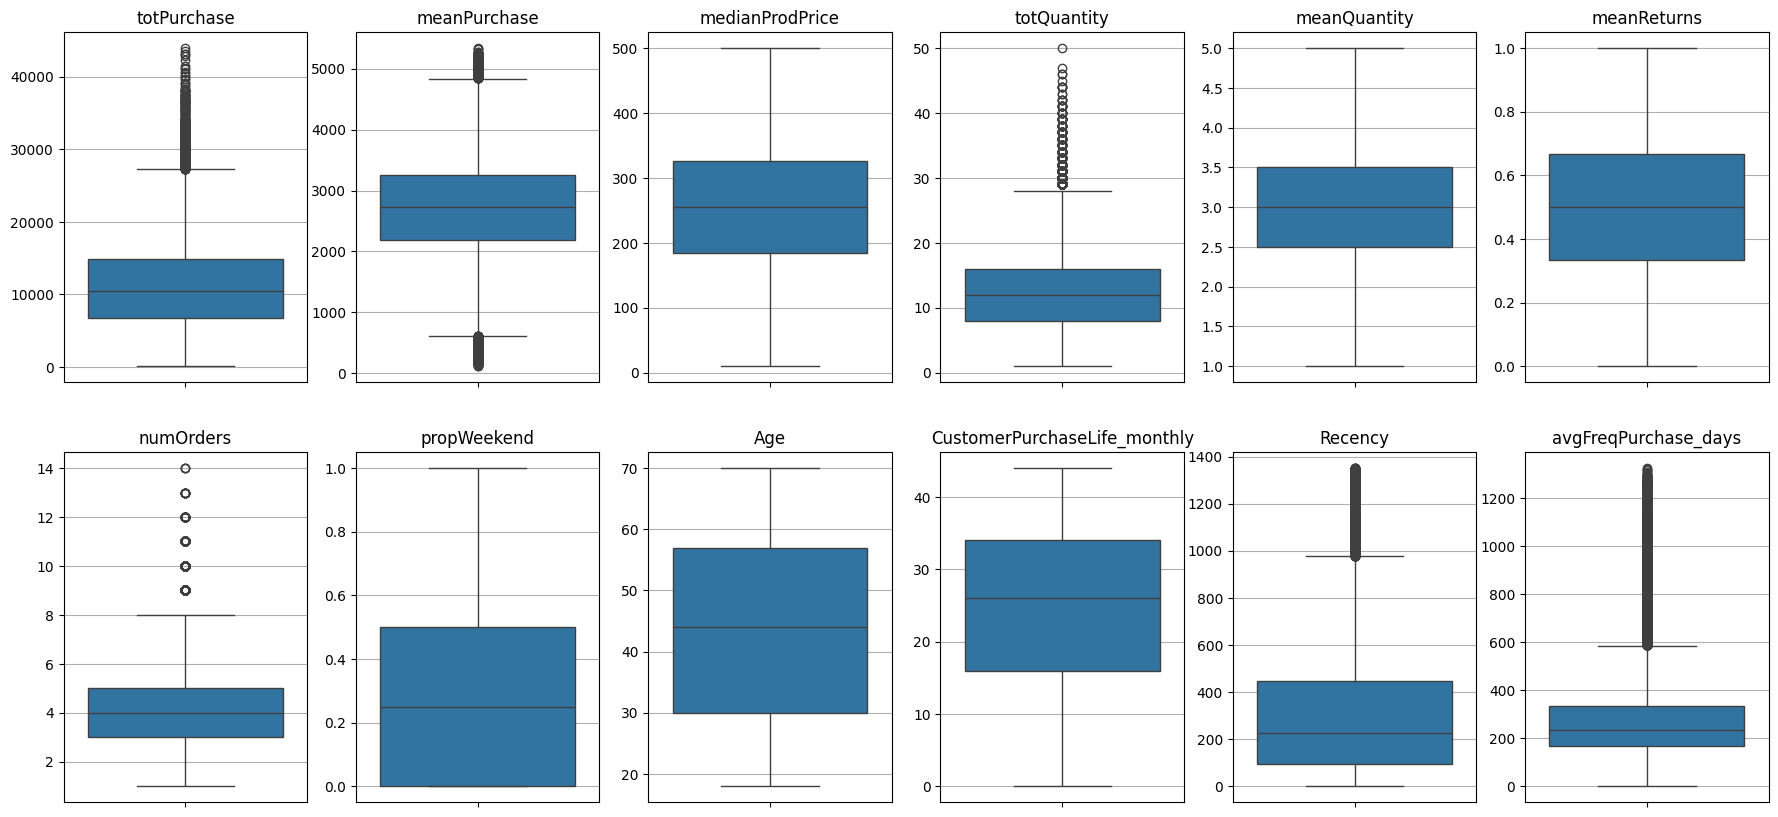

In [47]:
fig, axes = plt.subplots(2, 6, figsize=(22, 10))
axes = axes.ravel()

#  boxlot of the quantitativa vars
for i, col in enumerate(numericalVars[0:12]):
    sns.boxplot(y=data[col], ax=axes[i])  # boxplot
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel("")
    axes[i].grid(axis='y')

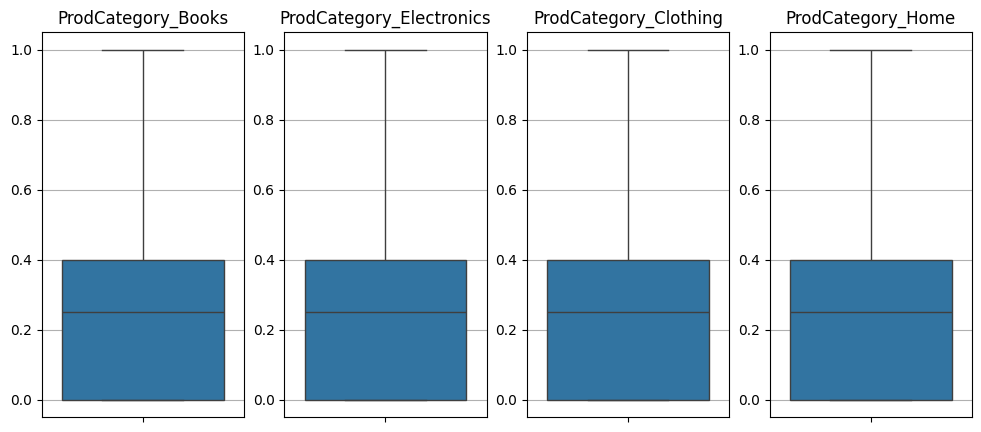

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(12,5))
axes = axes.ravel()

#  boxlot of the quantitativa vars
for i, col in enumerate(numericalVars[12:16]):
    sns.boxplot(y=data[col], ax=axes[i])  # boxplot
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel("")
    axes[i].grid(axis='y')

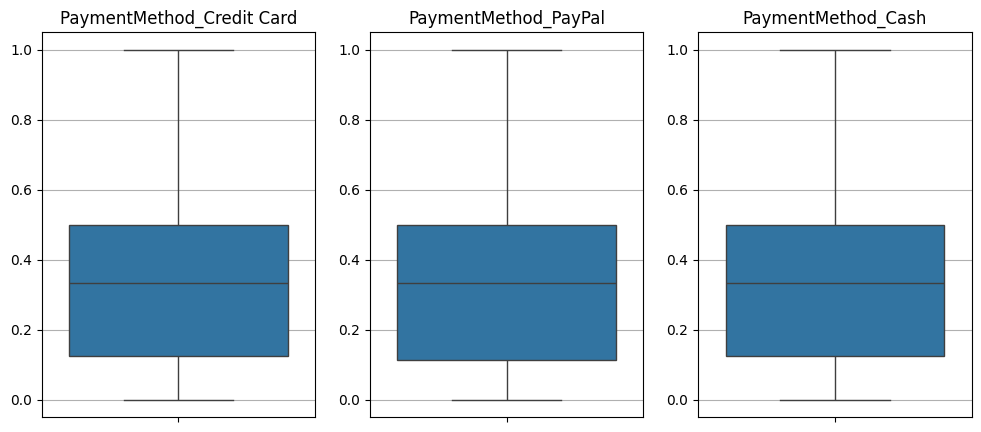

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12,5))
axes = axes.ravel()

#  boxlot of the quantitativa vars
for i, col in enumerate(numericalVars[16:19]):
    sns.boxplot(y=data[col], ax=axes[i])  # boxplot
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel("")
    axes[i].grid(axis='y')

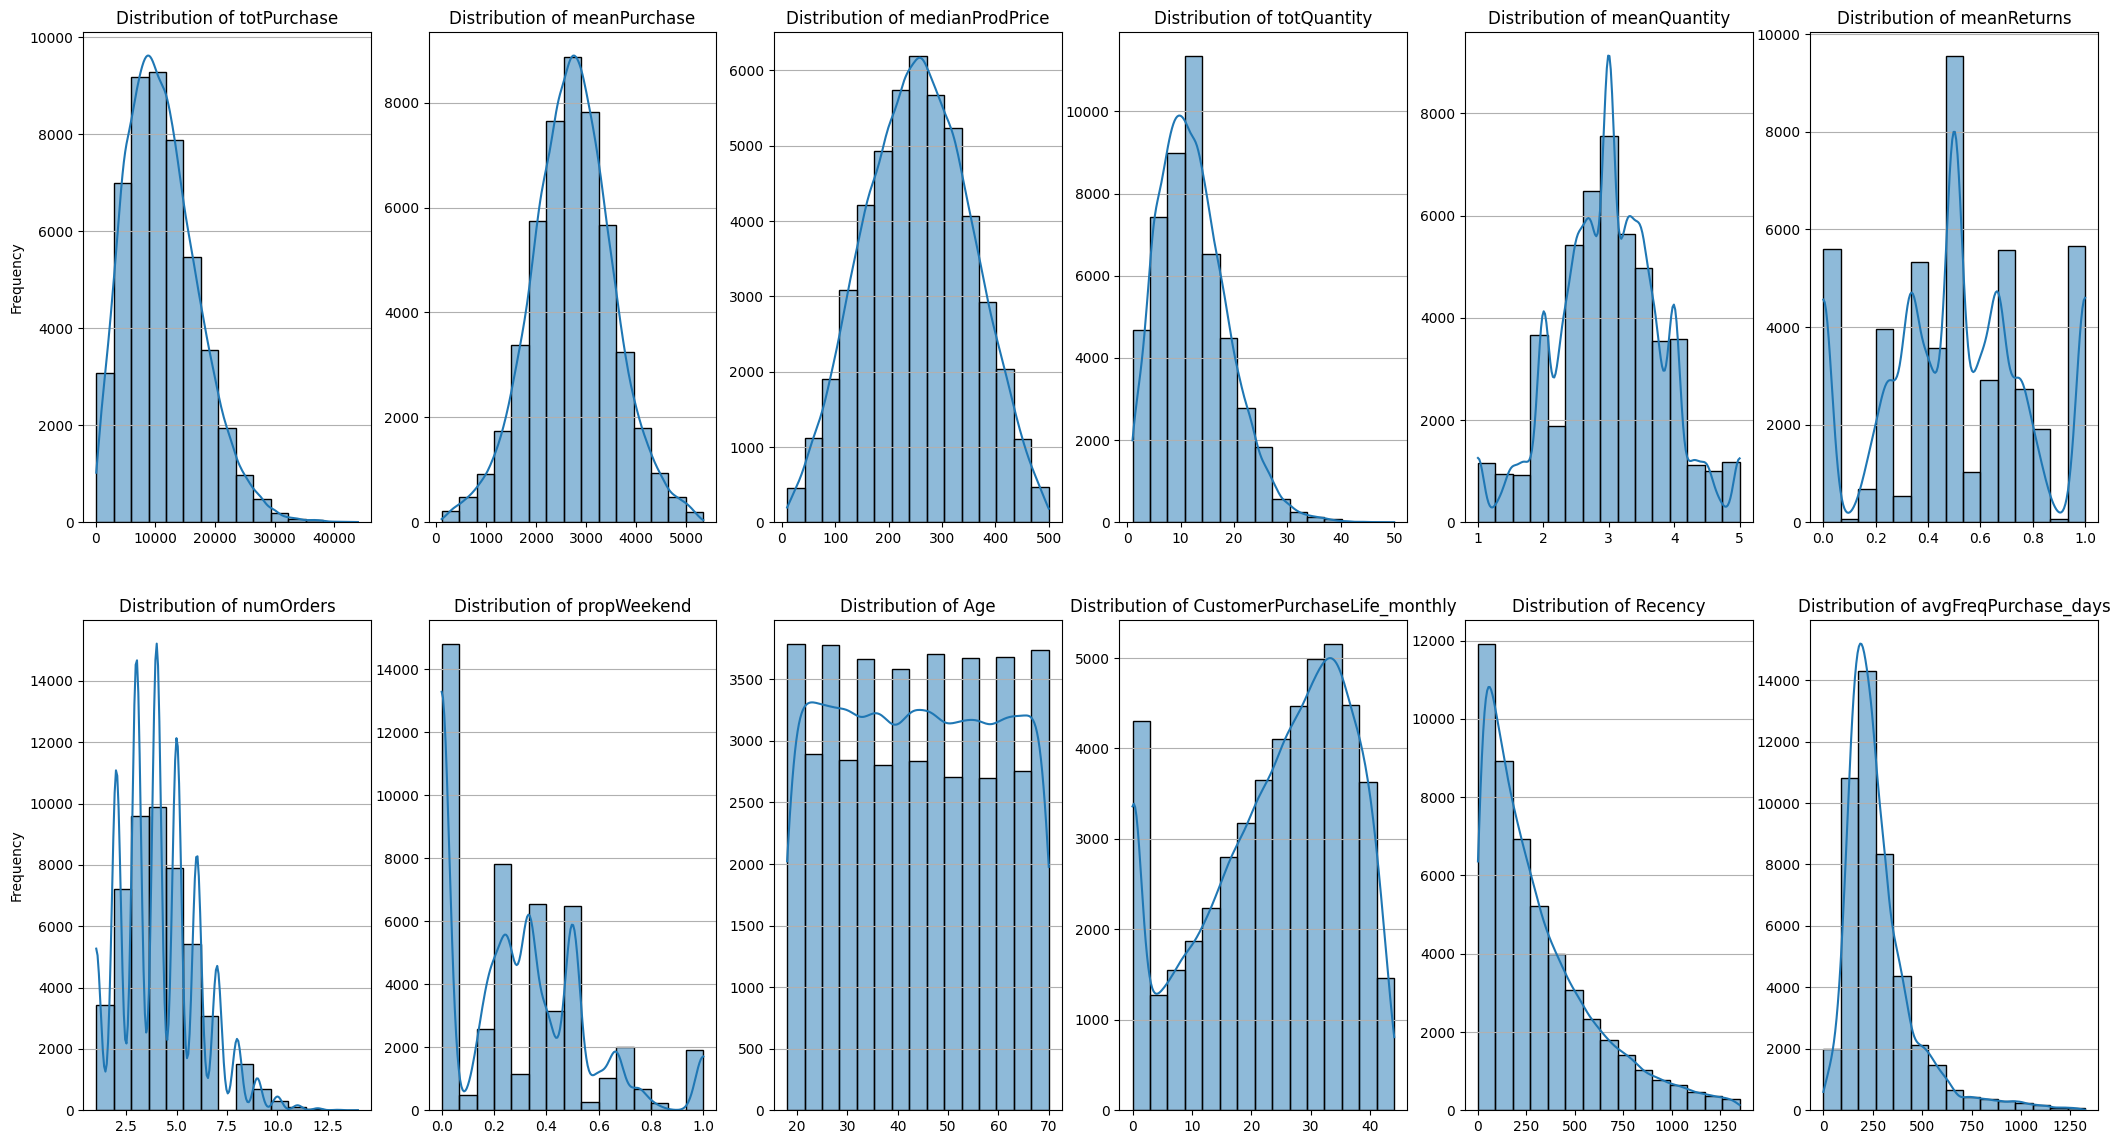

In [60]:
fig, axes = plt.subplots(2, 6, figsize=(26, 14))
axes = axes.ravel()

# histogram and distribution
for i, col in enumerate(numericalVars[0:12]):
    sns.histplot(data[col], kde=True, bins=15, ax=axes[i])  # density estimation
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[0].set_ylabel('Frequency')
    axes[6].set_ylabel('Frequency')
    axes[i].grid(axis='y')

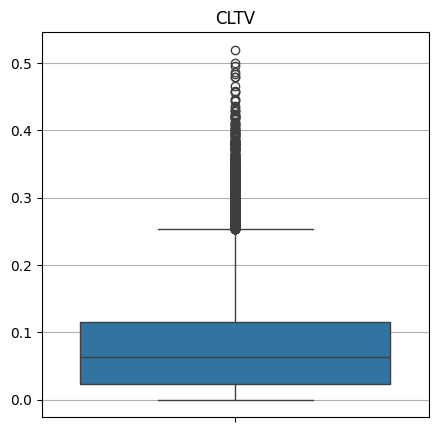

In [64]:
plt.figure(figsize=(5, 5))
sns.boxplot(dataAgg['CLTV'])
plt.title('CLTV')
plt.ylabel("")
plt.grid(axis='y')

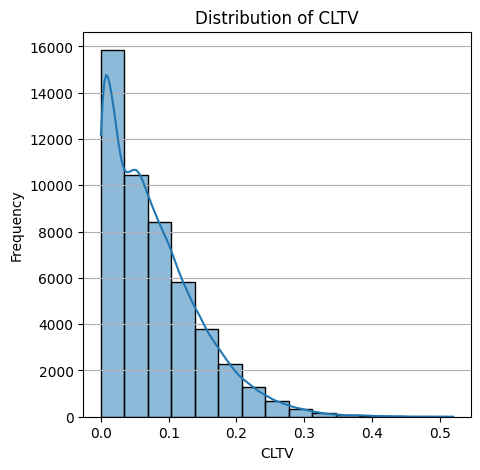

In [65]:
plt.figure(figsize=(5, 5))
sns.histplot(data['CLTV'], kde=True, bins=15)
plt.title(f'Distribution of CLTV')
plt.ylabel('Frequency')
plt.grid(axis='y')

In [66]:
dicotomVar = ['isMale', 'Churn']

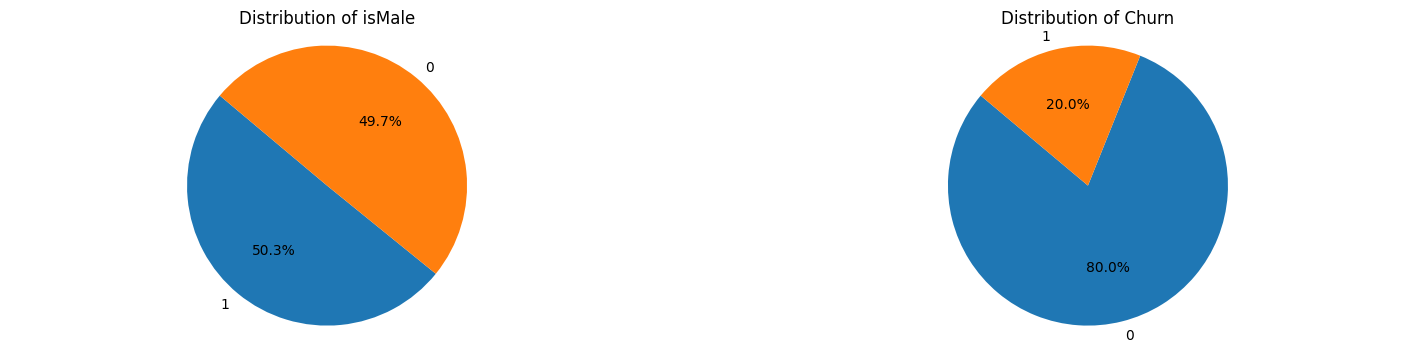

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
axes = axes.ravel()

# pie chart for the categorical vars
for i, col in enumerate(dicotomVar):
    axes[i].pie(data[col].value_counts(), labels=data[col].value_counts().index,
        autopct='%1.1f%%', startangle=140)
        # add percentages
    axes[i].set_title(f'Distribution of {col}')
    axes[i].axis('equal')  # round plot

(np.float64(-1.0999988560015657),
 np.float64(1.0999944063496025),
 np.float64(-1.0999990563867676),
 np.float64(1.099999477193105))

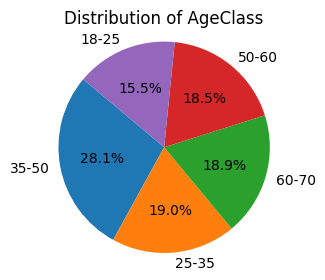

In [31]:
plt.figure(figsize=(3, 3))
plt.pie(dataAgg['AgeCut'].value_counts(), labels=dataAgg['AgeCut'].value_counts().index,
        autopct='%1.1f%%', startangle=140)
        # add percentages
plt.title('Distribution of AgeClass')
plt.axis('equal')  # round plot

In [35]:
dataAgg=dataAgg.drop(columns='AgeCut')

In [36]:
dataAgg.columns

Index(['Customer ID', 'totPurchase', 'meanPurchase', 'medianProdPrice',
       'totQuantity', 'meanQuantity', 'meanReturns', 'numOrders',
       'last_PurchaseDate', 'first_PurchaseDate', 'propWeekend', 'isMale',
       'Churn', 'Age', 'CustomerPurchaseLife_monthly', 'Recency',
       'avgFreqPurchase_days', 'AgeClass_18-25', 'AgeClass_25-35',
       'AgeClass_35-50', 'AgeClass_50-60', 'AgeClass_60-70',
       'ProdCategory_Books', 'ProdCategory_Electronics',
       'ProdCategory_Clothing', 'ProdCategory_Home',
       'PaymentMethod_Credit Card', 'PaymentMethod_PayPal',
       'PaymentMethod_Cash', 'CLTV'],
      dtype='object')

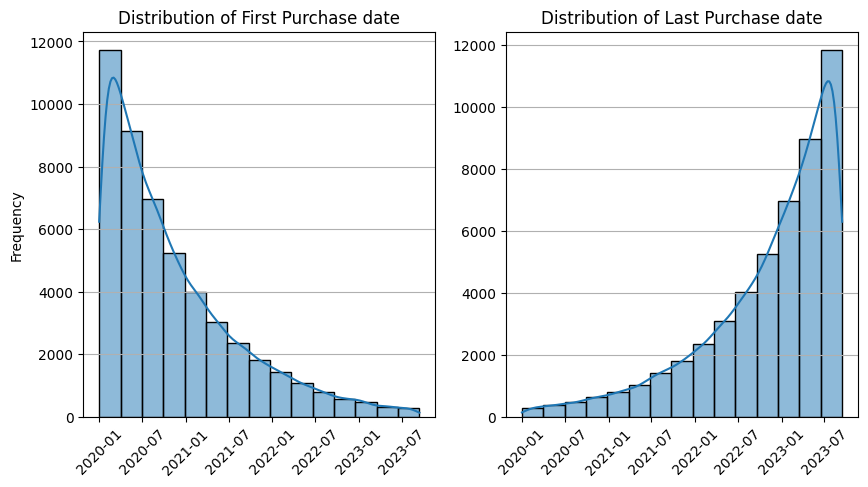

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

# histogram and distribution
sns.histplot(data['first_PurchaseDate'], kde=True, bins=15, ax=axes[0])  # density estimation
axes[0].set_title('Distribution of First Purchase date')
axes[0].set_xlabel("")
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y')
axes[0].tick_params(axis='x', rotation=45)


sns.histplot(data['last_PurchaseDate'], kde=True, bins=15, ax=axes[1])  # density estimation
axes[1].set_title('Distribution of Last Purchase date')
axes[1].set_xlabel("")
axes[1].set_ylabel('')
axes[1].grid(axis='y')
axes[1].tick_params(axis='x', rotation=45)

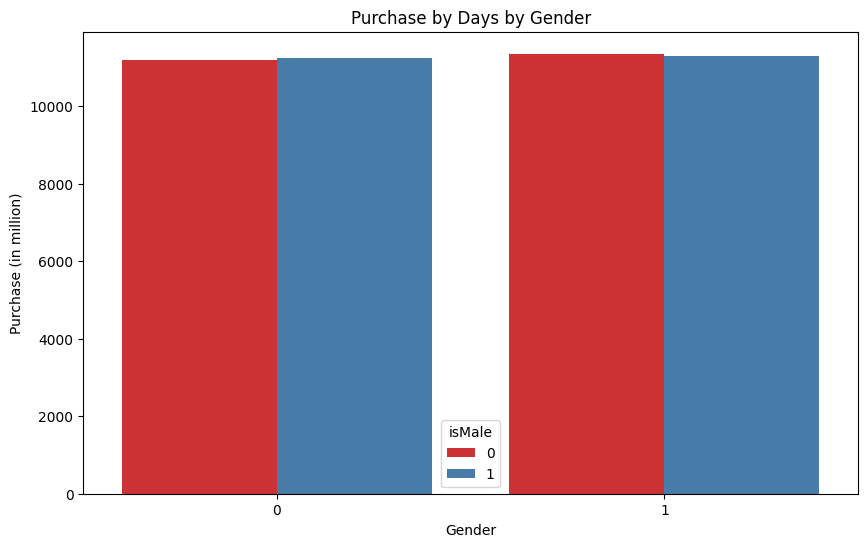

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Churn', y='totPurchase', data=data,
            hue='isMale', palette='Set1', errorbar=None)
plt.title('Purchase by Days by Gender')
plt.xlabel('Gender')
plt.ylabel('Purchase (in million)')
plt.show()

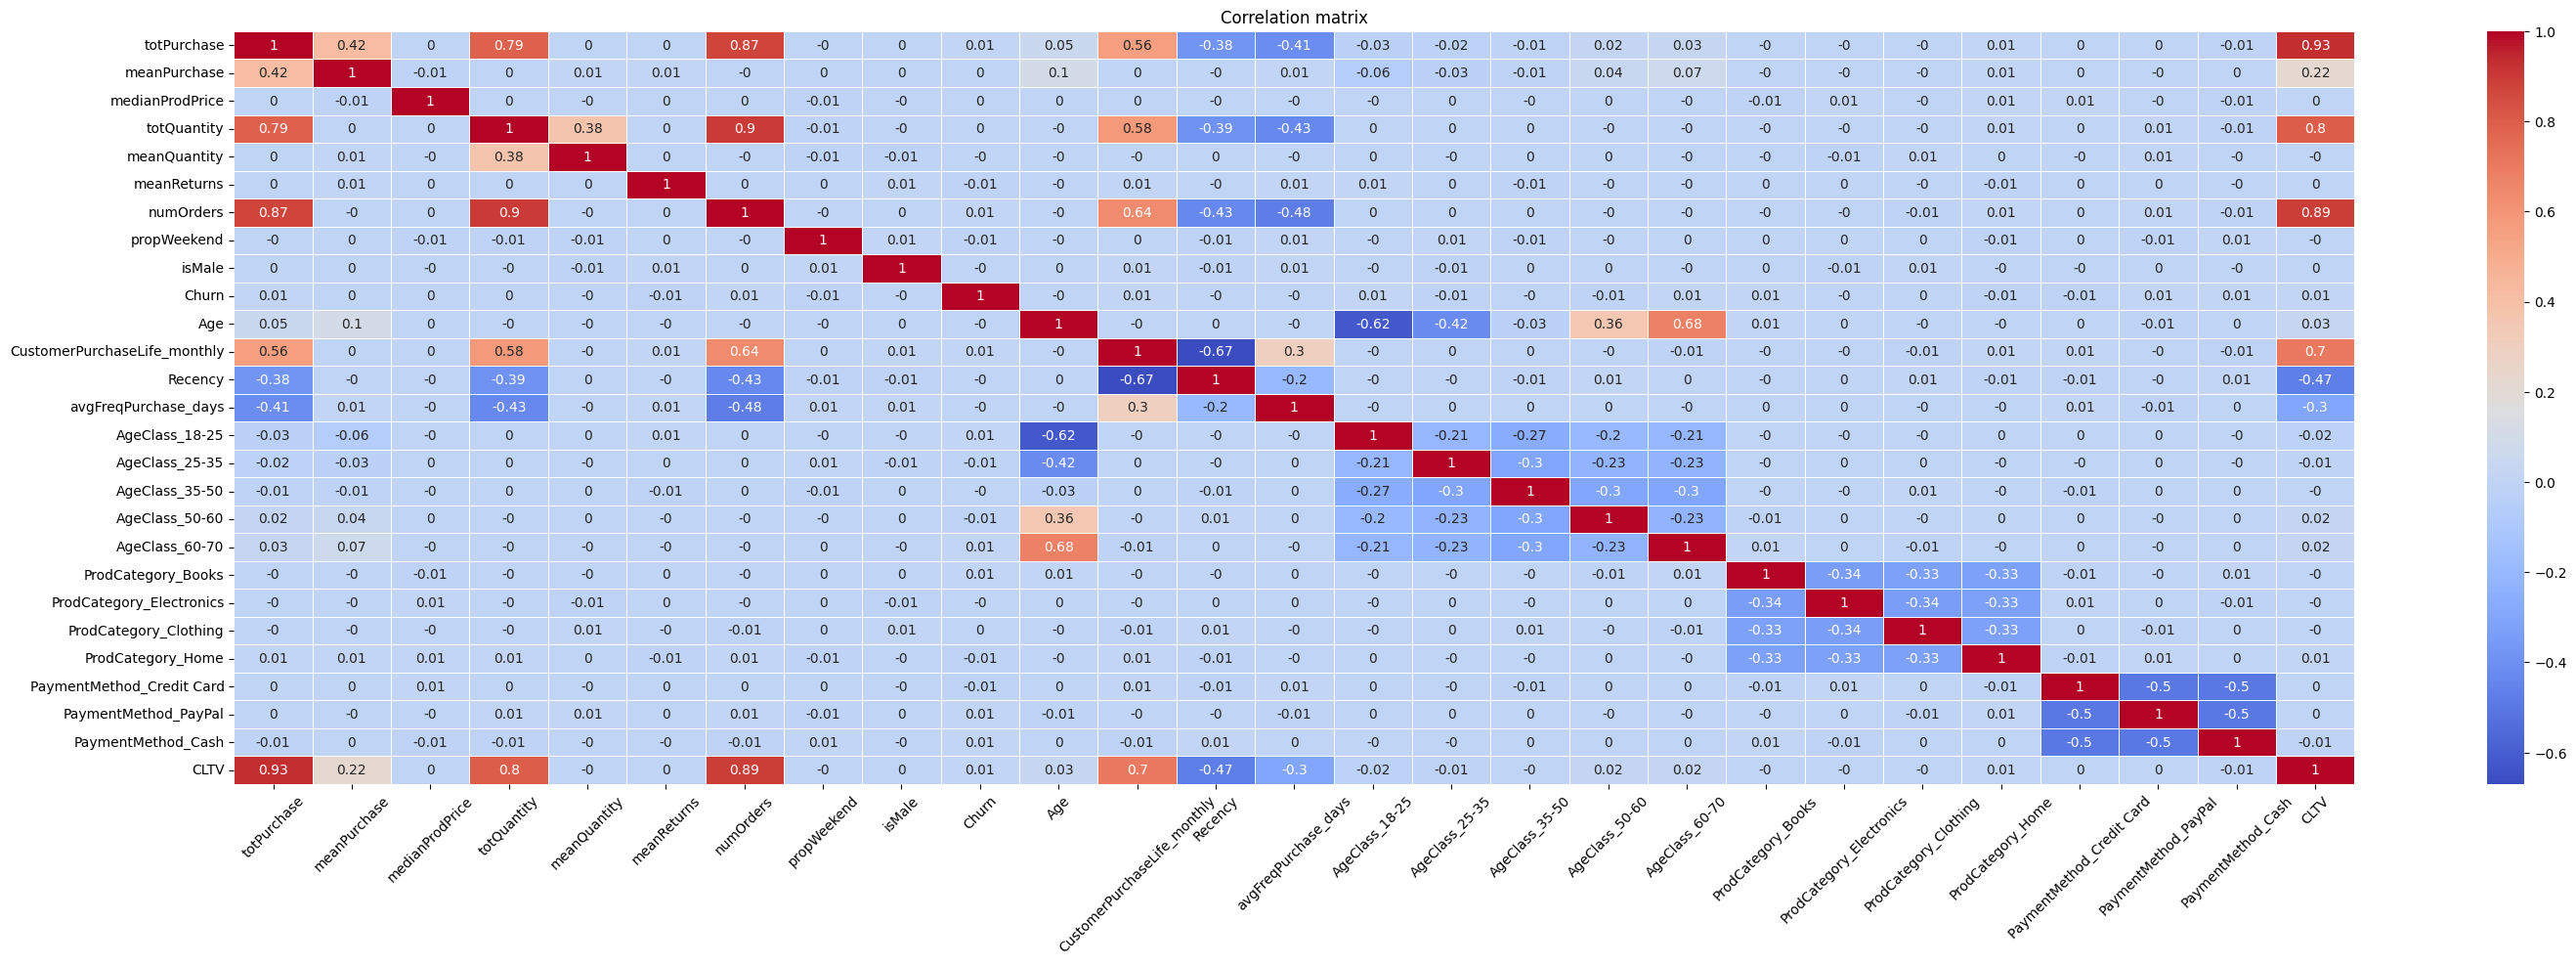

In [39]:
numericalVars = data.select_dtypes(include='number').columns
correlation_matrix = round(data[numericalVars].corr(), 2)

plt.figure(figsize=(35, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation matrix')
plt.xticks(rotation=45)
plt.show()